In [1]:
import pandas as pd 
import numpy as np

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 30 13:52:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [4]:
import tp1


In [5]:

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
import tensorflow.keras.backend as K
from affinity_loss import *
from datasets import inbalanced_mnist

import numpy as np
import os, tarfile
import matplotlib.pyplot as plt


def conv_bn_relu(input, ch):
    x = layers.Conv2D(ch, 3, padding="same")(input)
    x = layers.BatchNormalization()(x)
    return layers.Activation("relu")(x)

def create_models():
    input = layers.Input((28,28,1))
    x = conv_bn_relu(input, 32)
    x = layers.AveragePooling2D(2)(x)
    x = conv_bn_relu(x, 64)
    x = layers.AveragePooling2D(2)(x)
    x = conv_bn_relu(x, 128)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(2, name="latent_features", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = ClusteringAffinity(10, 1, 5.0)(x)

    return Model(input, x)

def acc(y_true_plusone, y_pred_plusone):
    y_true = K.argmax(y_true_plusone[:, :-1], axis=-1)
    y_pred = K.argmax(y_pred_plusone[:, :-1], axis=-1)
    equals = K.cast(K.equal(y_true, y_pred), "float")
    return K.mean(equals)

def step_decay(epoch):
    x = 1e-3
    if epoch >= 75: x /= 5.0
    return x

class EmbeddingCallback(Callback):
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train, self.y_train = X_train, y_train[:,:10]
        self.X_test, self.y_test = X_test, y_test[:,:10]

    def plot(self, X, y, title):
        plt.figure(figsize=(10,8))
        latent_model = Model(self.model.input, self.model.get_layer("latent_features").output)
        embedding = latent_model.predict(X, batch_size=128)
        plt.clf()
        cmap = plt.get_cmap("Set2")
        for i in range(y.shape[1]):
            filtered = y[:, i] == 1.0
            plt.scatter(embedding[filtered, 0], embedding[filtered, 1], marker="$"+str(i)+"$", alpha=0.5, color=cmap(i), )
        plt.savefig(title+".png")

    def on_epoch_end(self, epoch, logs):
        output_dir = "mnist_inbalanced"
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        self.plot(self.X_train, self.y_train, f"{output_dir}/mnist_train_{epoch:03}")
        self.plot(self.X_test, self.y_test, f"{output_dir}/mnist_test_{epoch:03}")

def train(inbalance_size, epochs = 200):
    (X_train, y_train), (X_test, y_test) = inbalanced_mnist(inbalance_size)

    model = create_models()
    model.compile("adam", affinity_loss(0.75), [acc])

    scheduler = LearningRateScheduler(step_decay)
    cb = EmbeddingCallback(model, X_train, X_test, y_train, y_test)

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[cb, scheduler],
                        batch_size=128, epochs=epochs, verbose=1).history

    with tarfile.open("mnist_inbalanced.tar", "w") as tar:
        tar.add("mnist_inbalanced")

In [ ]:
tf.config.list_physical_devices('GPU')

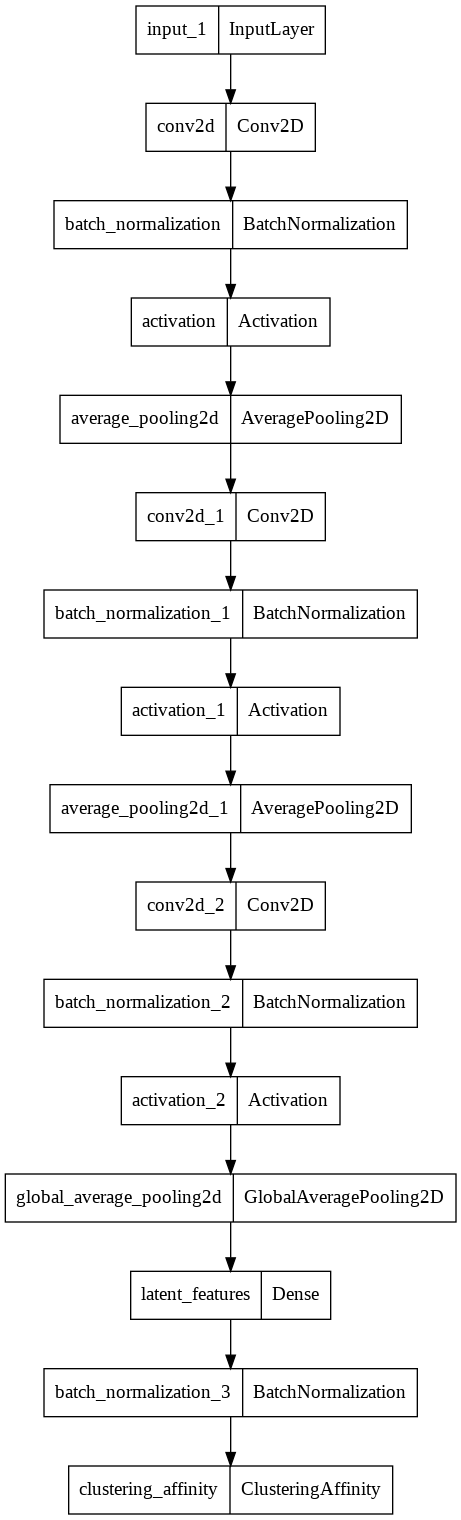

In [7]:
model = create_models()
tf.keras.utils.plot_model(
    model,
    to_file="model_cnn.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [ ]:
train(100, epochs = 200)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/200
262/262 [==============================] - 13s 15ms/step - loss: 5.0400 - acc: 0.4749 - val_loss: 8.3036 - val_acc: 0.0178 - lr: 0.0010
Epoch 2/200
262/262 [==============================] - 4s 13ms/step - loss: 4.3996 - acc: 0.6843 - val_loss: 5.0584 - val_acc: 0.4395 - lr: 0.0010
Epoch 3/200
262/262 [==============================] - 3s 13ms/step - loss: 4.2963 - acc: 0.7464 - val_loss: 4.5390 - val_acc: 0.5588 - lr: 0.0010
Epoch 4/200
262/262 [==============================] - 3s 13ms/step - loss: 4.2566 - acc: 0.8014 - val_loss: 4.4803 - val_acc: 0.6059 - lr: 0.0010
Epoch 5/200
262/262 [==============================] - 3s 12ms/step - loss: 4.2251 - acc: 0.8293 - val_loss: 4.3907 - val_acc: 0.7033 - lr: 0.0010
Epoch 6/200
262/262 [==============================] - 3s 13ms/step - loss: 4.1914 - acc: 0.8562 - val_loss: 5.1939 - val_acc: 0.5091 - lr: 0.0010
Epoch 7/200
262/262 [==============================]